# SimFin Tutorial 08 - Statistical Analysis

[Original repository on GitHub](https://github.com/simfin/simfin-tutorials)

This tutorial was originally written by [Hvass Labs](https://github.com/Hvass-Labs)

----

"So logically, if she weighs the same as a duck, she's made of wood, and therefore a witch!"
&ndash; [Monty Python's Holy Grail](https://www.youtube.com/watch?v=zrzMhU_4m-g)

## Introduction

In the previous tutorial we showed how to implement a basic stock-screener using the SimFin API and financial data. One of the screeners we created was for so-called NetNet-stocks, which are stocks that sell at a discount to a very conservative estimate of their liquidation value. This is an old investment strategy invented by Ben Graham, who was the teacher of Warren Buffett.

The previous tutorial was a good example of how people use stock-screeners: They have some hypothesis that a given valuation ratio or other financial signal can be used to predict future stock-returns. But how can we really know that there is a relation between some financial signal and future stock-returns? The first step is to use statistical analysis, which is the topic of this tutorial.

We will again use the NetNet example because it is simple and demonstrates the method well. But we could also have studied e.g. how financial signals might predict future sales-growth, or whatever else we might be interested in.

It is assumed you are already familiar with the basics of the SimFin API.

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
# Version of the SimFin Python API.
sf.__version__

'0.3.0'

## SimFin Config

In [3]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [4]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [5]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Data Hub

We use a `StockHub` object to easily load and process financial data with these settings:

In [6]:
# We are interested in the US stock-market.
market = 'us'

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

In [7]:
%%time
hub = sf.StockHub(market=market, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

CPU times: user 20 µs, sys: 1 µs, total: 21 µs
Wall time: 25.7 µs


## Signals

First we calculate financial signals for the stocks, such as the Current Ratio, Debt Ratio, Net Profit Margin, Return on Assets, etc. These are calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [8]:
%%time
df_fin_signals = hub.fin_signals(variant='daily')

Dataset "us-income-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-2a38bb7d.pickle' on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 17.1 s, sys: 1.37 s, total: 18.5 s
Wall time: 17 s


Now we calculate growth signals for the stocks, such as Earnings Growth, FCF Growth, Sales Growth, etc. These are also calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [9]:
%%time
df_growth_signals = hub.growth_signals(variant='daily')

Dataset "us-income-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-2a38bb7d.pickle' on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 900 ms, sys: 244 ms, total: 1.14 s
Wall time: 1.14 s


Now we calculate valuation signals for the stocks, such as P/E, P/Sales, etc. These are calculated from the share-prices and data from the financial reports. Because the data-hub has already loaded the required datasets in the function-calls above, the data is merely reused here, and the data-hub can proceed directly to computing the signals.

In [10]:
%%time
df_val_signals = hub.val_signals(variant='daily')

Cache-file 'val_signals-739b68a6.pickle' on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 170 ms, sys: 300 ms, total: 470 ms
Wall time: 469 ms


We now combine all the signals into a single DataFrame:

In [11]:
%%time
# Combine the DataFrames.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

CPU times: user 6.17 s, sys: 923 ms, total: 7.09 s
Wall time: 2 s


We can then show the results:

In [12]:
df_signals.dropna(how='all').head()

Asset Turnover  Current Ratio  Debt Ratio  \
Ticker Date                                                    
A      2011-06-29             NaN       3.201005     0.24789   
       2011-06-30             NaN       3.201005     0.24789   
       2011-07-01             NaN       3.201005     0.24789   
       2011-07-05             NaN       3.201005     0.24789   
       2011-07-06             NaN       3.201005     0.24789   

                   Gross Profit Margin  Net Profit Margin  Return on Assets  \
Ticker Date                                                                   
A      2011-06-29             0.532001           0.144574               NaN   
       2011-06-30             0.532001           0.144574               NaN   
       2011-07-01             0.532001           0.144574               NaN   
       2011-07-05             0.532001           0.144574               NaN   
       2011-07-06             0.532001           0.144574               NaN   

                   Return on Equity  Earnings Growth  Earnings Growth QOQ  \
Ticker Date                                                                 
A      2011-06-29               NaN              NaN                  NaN   
       2011-06-30               NaN              NaN                  NaN   
       2011-07-01               NaN              NaN                  NaN   
       2011-07-05               NaN              NaN                  NaN   
       2011-07-06               NaN              NaN                  NaN   

                   Earnings Growth YOY  ...  Dividend Yield  Earnings Yield  \
Ticker Date                             ...                                   
A      2011-06-29                  NaN  ...             NaN        0.049626   
       2011-06-30                  NaN  ...             NaN        0.049121   
       2011-07-01                  NaN  ...             NaN        0.048280   
       2011-07-05                  NaN  ...             NaN        0.048598   
       2011-07-06                  NaN  ...             NaN        0.048448   

                   FCF Yield    Market-Cap    P/Book        P/E      P/FCF  \
Ticker Date                                                                  
A      2011-06-29   0.045221  1.793416e+10  4.527684  20.150736  22.113631   
       2011-06-30   0.044761  1.811850e+10  4.574222  20.357860  22.340931   
       2011-07-01   0.043995  1.843400e+10  4.653875  20.712360  22.729963   
       2011-07-05   0.044284  1.831347e+10  4.623446  20.576933  22.581344   
       2011-07-06   0.044148  1.837019e+10  4.637766  20.640663  22.651282   

                      P/NCAV   P/NetNet   P/Sales  
Ticker Date                                        
A      2011-06-29  43.956262 -29.990226  2.913281  
       2011-06-30  44.408076 -30.298487  2.943225  
       2011-07-01  45.181373 -30.826087  2.994477  
       2011-07-05  44.885956 -30.624532  2.974898  
       2011-07-06  45.024975 -30.719381  2.984111  

[5 rows x 26 columns]

## Missing Data

Some of the signals have a lot of missing data which causes problems in the statistical analysis. Let us first see the fraction of each signal-column that is missing:

In [13]:
# Remove all rows with only NaN values.
df = df_signals.dropna(how='all').reset_index(drop=True)

# For each column, show the fraction of the rows that are NaN.
(df.isnull().sum() / len(df)).sort_values(ascending=False)

Dividend Yield         0.533772
Debt Ratio             0.324557
Sales Growth           0.227931
Asset Turnover         0.224232
Earnings Growth        0.212780
Return on Assets       0.212388
Return on Equity       0.212388
FCF Growth             0.212388
Sales Growth YOY       0.198149
Earnings Growth YOY    0.184320
FCF Growth YOY         0.183868
P/Sales                0.105850
Sales Growth QOQ       0.095425
Earnings Yield         0.091799
P/NetNet               0.091799
FCF Yield              0.091799
Market-Cap             0.091799
P/Book                 0.091799
P/E                    0.091799
P/FCF                  0.091799
P/NCAV                 0.091799
Gross Profit Margin    0.083246
Net Profit Margin      0.080159
Earnings Growth QOQ    0.077892
FCF Growth QOQ         0.077380
Current Ratio          0.065622
dtype: float64

As you can see from the above list, the Dividend Yield has missing data for nearly half of its rows, while the Debt Ratio has missing data for a third of its rows. Let us remove all signals that have more than 25% missing data:

In [14]:
# List of the columns before removing any.
columns_before = df_signals.columns

# Threshold for the number of rows that must be NaN for each column.
thresh = 0.75 * len(df_signals.dropna(how='all'))

# Remove all columns which don't have sufficient data.
df_signals = df_signals.dropna(axis='columns', thresh=thresh)

# List of the columns after the removal.
columns_after = df_signals.columns

# Show the columns that were removed.
columns_before.difference(columns_after)

Index(['Debt Ratio', 'Dividend Yield'], dtype='object')

## Screener for NetNet Stocks

We want to test whether the NetNet investment strategy might work, so we will only use the signal-rows that have a P/NetNet ratio between zero and one, thus indicating the stock is trading at a discount to its NetNet liquidation estimate. We create this stock-screener by making a boolean mask as follows:

In [15]:
mask_netnet = (df_signals[P_NETNET] > 0) \
            & (df_signals[P_NETNET] < 1)

Rows that satisfy the screener-condition have a value of `True` and rows that do not meet the condition have a value of `False`.

In [16]:
mask_netnet.head()

Ticker  Date      
A       2007-01-03    False
        2007-01-04    False
        2007-01-05    False
        2007-01-08    False
        2007-01-09    False
Name: P/NetNet, dtype: bool

We can then use the boolean mask to select matching rows in the signal DataFrame:

In [17]:
df_signals.loc[mask_netnet, P_NETNET]

Ticker  Date      
ADIL    2019-05-30    0.464160
        2019-05-31    0.410860
        2019-06-03    0.406418
        2019-06-04    0.401976
        2019-06-05    0.426406
                        ...   
ZYNE    2019-01-22    0.931908
        2019-01-23    0.899429
        2019-01-24    0.911921
        2019-01-25    0.941902
        2019-01-28    0.959391
Name: P/NetNet, Length: 20027, dtype: float64

## Historical NetNet Stocks

Let us plot how many different stocks have traded at NetNet-discounts in the past. The SimFin dataset is not complete, because it currently only contains a subset of all US stocks, and the SimFin dataset mostly contains larger stocks while NetNet-stocks are typically smaller stocks. Furthermore, the SimFin financial data such as Balance Sheets, currently only goes back to around 2010 for larger stocks and maybe even less for small stocks. So in reality there are probably many more NetNet-stocks than shown in this plot. For example, during the Financial Crisis in 2008-2009 there were many stocks that traded at NetNet-discounts for a few months, but that data is currently not in the SimFin database.

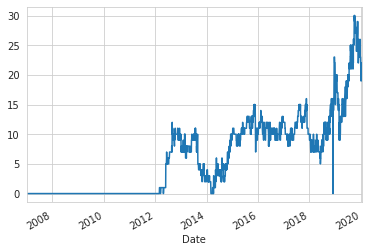

In [18]:
mask_netnet.groupby(DATE).sum().plot(grid=True)

We can also show all the tickers that have traded at NetNet discounts at some point:

In [19]:
tickers_netnet = mask_netnet[mask_netnet].reset_index()[TICKER].unique()
print('Number of unique tickers:', len(tickers_netnet))
print(tickers_netnet)

Number of unique tickers: 89
['ADIL' 'ADVM' 'AGLE' 'AHPI' 'AKER' 'ALPN' 'ALRN' 'AMDA' 'AMSC' 'ARQL'
 'ASTC' 'AVEO' 'AVGR' 'AWRE' 'BLFS' 'BSPM' 'BTAI' 'BVSN' 'CALA' 'CDI'
 'CDNA' 'CGA' 'CLBS' 'CLNT' 'CLRB' 'CRVS' 'CUO' 'CVSI' 'CYCC' 'CYIG'
 'EFOI' 'EVLO' 'FORD' 'FORM' 'FPRX' 'GENC' 'GLYC' 'GTXI' 'HGEN' 'IAIC'
 'IFON' 'IPDN' 'KKR' 'KURA' 'LEDS' 'LGL' 'LTRX' 'MB' 'MEIP' 'MICT' 'MN'
 'MNKD' 'MRSN' 'MTEM' 'MXPT' 'MYSZ' 'NHTC' 'NLNK' 'NSPR' 'OFLX' 'ONVO'
 'OPHT' 'PACB' 'PSDV' 'PTE' 'PTN' 'RIGL' 'RKDA' 'RUBI' 'RWLK' 'SCND'
 'SIGN' 'SOHU' 'SORL' 'SPRT' 'SRPT' 'SRRA' 'SURF' 'TGTX' 'TMED' 'TOCA'
 'TROV' 'UMRX' 'VIDE' 'VLRX' 'VSTM' 'WSTL' 'XPO' 'ZYNE']


## 1-Day Returns

Let us now compare the P/NetNet ratio to 1-day stock-returns.

In [20]:
# Name of the new column for the returns.
TOTAL_RETURN_1D = 'Total Return 1-Day'

In [21]:
%%time
# Calculate 1-day stock-returns.
df_returns_1d = hub.returns(name=TOTAL_RETURN_1D,
                            bdays=1, future=True, annualized=False)

Cache-file 'rel_change-20196410.pickle' on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 66.3 ms, sys: 31.7 ms, total: 98 ms
Wall time: 98.3 ms


In [22]:
# Show the 1-day stock-returns.
df_returns_1d.loc[mask_netnet]

Ticker  Date      
ADIL    2019-05-30   -0.114833
        2019-05-31   -0.010811
        2019-06-03   -0.010929
        2019-06-04    0.060773
        2019-06-05    0.067708
                        ...   
ZYNE    2019-01-22   -0.034853
        2019-01-23    0.013889
        2019-01-24    0.032877
        2019-01-25    0.018568
        2019-01-28    0.252604
Name: Total Return 1-Day, Length: 20027, dtype: float64

In [23]:
# Limit the daily returns between -10% and +10%
df_returns_1d = df_returns_1d.clip(-0.1, 0.1)

# Combine the signals and stock-returns.
# We are only using the rows which are NetNet discounts.
dfs = [df_signals.loc[mask_netnet],
       df_returns_1d.loc[mask_netnet]]
df_sig_rets = pd.concat(dfs, axis=1)

We can then make a scatter-plot of the P/NetNet ratio versus the daily stock-returns:

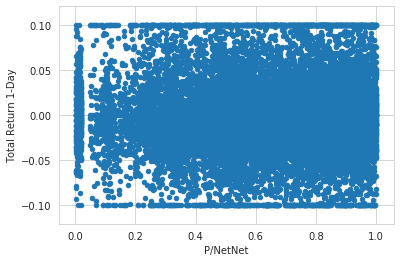

In [24]:
df_sig_rets.plot(kind='scatter', grid=True,
                 x=P_NETNET, y=TOTAL_RETURN_1D)

We can also use colours to distinguish the dots for different tickers:

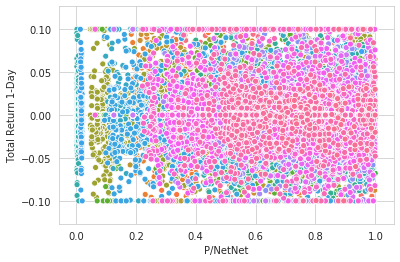

In [25]:
sns.scatterplot(x=P_NETNET, y=TOTAL_RETURN_1D, hue=TICKER,
                data=df_sig_rets.reset_index(), legend=False)

As you can see from the plots above, there is no clear relation between the P/NetNet ratio and daily stock-returns. The plot looks completely random and there is a very good reason for this, because the P/NetNet ratio is composed of two items: The daily share-price divided by the NetNet-value, which is calculated using data from the last-known quarterly Balance Sheet. So the NetNet value is the exact same for every single day for 3 months at a time. So we are essentially trying to use the share-price to predict 1-day stock-returns, which is quite moronic! This is also the case for other valuation ratios and signals that rely on data from the quarterly Income Statements, Balance Sheets and Cash-Flow Statements. Because that data will be exactly the same for 3 months at a time, so it cannot be used to predict short-term stock-returns.

## 1-3 Year Returns

Let us instead study the relation between the P/NetNet ratio and the average stock-returns for all 1-3 year investment periods. We will actually consider the mean log-returns, because that is easier to calculate, but the result is nearly the same as the non-log mean returns.

In [26]:
# Name of the new column for the returns.
TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

In [27]:
%%time
# Calculate the mean log-returns for all 1-3 year periods.
df_returns_1_3y = \
    hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
                         future=True, annualized=True,
                         min_years=1, max_years=3)

Cache-file 'mean_log_change-5cec82bd.pickle' on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 48.1 ms, sys: 48 ms, total: 96.1 ms
Wall time: 95 ms


In [28]:
# Combine the signals and stock-returns.
# We are only using the rows which are NetNet discounts.
dfs = [df_signals.loc[mask_netnet],
       df_returns_1_3y.loc[mask_netnet]]
df_sig_rets = pd.concat(dfs, axis=1)

Let us now make a scatter-plot of the P/NetNet ratio versus the 1-3 year average stock-returns. We use different colours for the individual tickers. There seems to be some kind of downward-sloping curves in this plot, but the outliers makes it a bit hard to see:

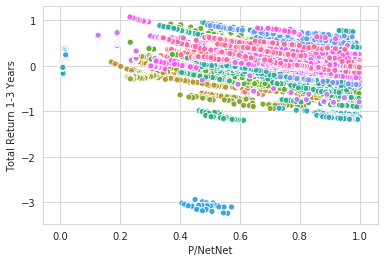

In [29]:
sns.scatterplot(x=P_NETNET, y=TOTAL_RETURN_1_3Y, hue=TICKER,
                data=df_sig_rets.reset_index(), legend=False)

## Winsorize Data

A common method for removing outliers is so-called *Winsorization* of the data. It basically just limits or clips the data between e.g. the 5% and 95% quantiles of the data. We will Winsorize the stock-returns and all the signals except the P/NetNet ratio, because that is already limited between zero and one by using the stock-screener criterion above.

In [30]:
# Select all columns except for the P/NetNet ratio.
columns = df_sig_rets.columns.drop(P_NETNET)

# Winsorize all the other signals and stock-returns.
df_sig_rets2 = sf.winsorize(df_sig_rets, columns=columns)

We can now repeat the above scatter-plot for the P/NetNet ratio versus the 1-3 year average stock-returns. The colours are again for the different stock-tickers:

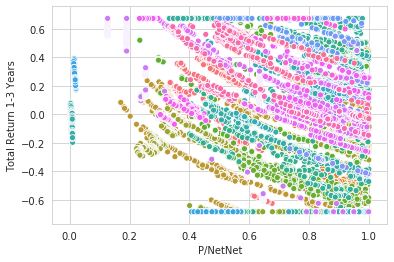

In [31]:
sns.scatterplot(x=P_NETNET, y=TOTAL_RETURN_1_3Y, hue=TICKER,
                data=df_sig_rets2.reset_index(), legend=False)

Note how some of the values on the y-axis are squashed at the upper and lower boundaries, which is due to the clipping or limiting done in the Winsorization. This clipping is also done on all the signals, which may cause problems for the statistical analysis.

We can pass the argument `clip=False` to the Winsorization function, so instead of clipping or limiting all the values beyond the 5% and 95% quantiles, it simply sets them to `NaN` (Not-a-Number), so they will be ignored in the statistical analysis:

In [32]:
# Winsorize all the other signals and stock-returns.
# Instead of clipping values beyond the bounds, set them to NaN.
df_sig_rets = sf.winsorize(df_sig_rets, columns=columns, clip=False)

We can then make the scatter-plot again, where we see that all the clipped / squashed values at the upper and lower boundaries are now gone:

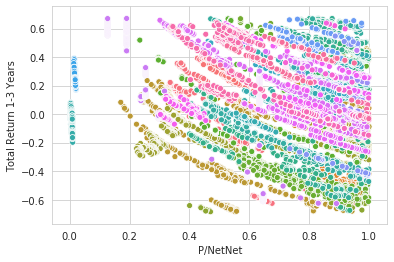

In [33]:
sns.scatterplot(x=P_NETNET, y=TOTAL_RETURN_1_3Y, hue=TICKER,
                data=df_sig_rets.reset_index(), legend=False)

The downard-sloping curves are now very clear in the plot above, if you separate the curves according to the different ticker-colours. The curves look so regular, that there must be some formula that governs their shape, so it would seem possible to predict the future stock-returns from the P/NetNet ratio, if we could also determine the *magic number* that shifts the curve up or down for the different stocks. We will discuss this towards the end of this tutorial. Let us now proceed with the statistical analysis of the other signals.

## Linear Correlation

Linear correlation (aka. Pearson correlation) is a simple statistical measure of how two variables change together. We will study the linear correlation between the signals and stock-returns, to roughly assess which signals might be the best predictors for stock-returns. We will also study the linear correlation between the signals themselves, to assess whether some of the signals seem to be redundant and can be removed.

A correlation value of +1 means the two variables are perfectly correlated, so they always increase and decrease together in a linear way. Conversely, a correlation value of -1 means the two variables are perfectly inversely correlated, so they always increase and decrease in the opposite direction of each other. A correlation value of zero means that there is no linear relation between the signal and stock-returns, but there may still be a strong non-linear relation (see examples [here](https://en.wikipedia.org/wiki/Correlation_and_dependence)).

We use the Winsorized data when studying the correlation, because data-outliers may falsely indicate a strong overall correlation, when in fact there is no correlation for the majority of the data.

Let us first show the correlation between all the signals and the 1-3 year average stock-returns, sorted according to the absolute correlation strength:

In [34]:
# Calculate the correlation between all signals and stock-returns.
df_corr = df_sig_rets.corr()

# Show how the signals are correlated with the stock-returns.
# Sorted to show the strongest absolute correlations first.
df_corr_returns = df_corr[TOTAL_RETURN_1_3Y].abs().sort_values(ascending=False)
df_corr_returns

Total Return 1-3 Years    1.000000
Gross Profit Margin       0.385123
Sales Growth QOQ          0.182915
Sales Growth              0.181070
Net Profit Margin         0.158238
P/NetNet                  0.153503
Current Ratio             0.149016
FCF Growth                0.126669
Return on Equity          0.118222
Market-Cap                0.091885
P/NCAV                    0.090541
Earnings Growth           0.077797
Return on Assets          0.063992
FCF Growth YOY            0.054319
P/Book                    0.048748
Sales Growth YOY          0.044010
Earnings Growth QOQ       0.041633
FCF Yield                 0.038336
Earnings Yield            0.025016
P/FCF                     0.021676
Earnings Growth YOY       0.016336
P/E                       0.006658
P/Sales                   0.002635
Asset Turnover            0.002157
FCF Growth QOQ            0.001978
Name: Total Return 1-3 Years, dtype: float64

We can also show a correlation-matrix between all the signals and the 1-3 year average stock-returns. Note that all correlations on the diagonal are 1 because each signal is perfectly correlated with itself. You should look for correlation values that are close to +1 or -1 because it means the two signals are redundant.

In [35]:
df_corr.round(2).style.background_gradient(cmap='seismic', axis=None)

,Asset Turnover,Current Ratio,Gross Profit Margin,Net Profit Margin,Return on Assets,Return on Equity,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,Sales Growth QOQ,Sales Growth YOY,Earnings Yield,FCF Yield,Market-Cap,P/Book,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales,Total Return 1-3 Years
Asset Turnover,1,-0.09,-0.64,0.57,0.33,0.31,-0.01,-0.02,-0.23,-0.35,-0.18,-0.32,0.29,-0.01,0.16,0.19,0.28,-0.06,-0.09,-0.05,0.54,0.01,0.22,-0.49,0
Current Ratio,-0.09,1,0.15,-0.2,0.1,0.16,0.08,-0,0.1,0.22,-0.03,0.13,-0.02,0.11,0.04,0.14,0.2,0.38,0.26,0.11,-0.06,0.26,0.13,0.24,0.15
Gross Profit Margin,-0.64,0.15,1,-0.56,-0.36,-0.29,0.11,-0.05,0.14,0.27,0.12,0.08,-0.39,-0.03,-0.25,-0.1,-0.14,0.12,0.27,-0.23,-0.27,0.19,0.06,0.53,-0.39
Net Profit Margin,0.57,-0.2,-0.56,1,0.3,0.26,-0.11,0.07,-0.12,-0.19,-0.15,-0.07,0.1,-0.1,-0.1,0.18,0.18,-0.2,-0.16,0.2,0.21,-0.05,0.01,-0.86,0.16
Return on Assets,0.33,0.1,-0.36,0.3,1,0.92,-0.15,0.07,-0.17,-0.25,-0.12,-0.08,0.1,0.12,0.1,0.75,0.63,0.13,-0.29,0.4,0.15,-0.15,-0.1,-0.27,0.06
Return on Equity,0.31,0.16,-0.29,0.26,0.92,1,-0.1,0.05,-0.16,-0.24,-0.1,-0.02,0.15,0.02,0.04,0.8,0.7,0.17,-0.19,0.35,0.11,-0.06,-0.03,-0.23,0.12
Earnings Growth,-0.01,0.08,0.11,-0.11,-0.15,-0.1,1,-0.11,0.34,0.33,0.09,0.19,0.25,0.11,0.14,-0.01,0.13,0.13,0.01,0.05,0.07,-0.04,0.1,0.22,0.08
Earnings Growth QOQ,-0.02,-0,-0.05,0.07,0.07,0.05,-0.11,1,0.02,-0.01,-0.16,0.08,-0.07,-0.07,-0.03,-0,-0.03,0.03,-0.03,0,-0.11,-0.04,-0.1,-0.03,-0.04
Earnings Growth YOY,-0.23,0.1,0.14,-0.12,-0.17,-0.16,0.34,0.02,1,0.19,0.2,0.15,0.05,0,0.09,-0.09,-0.01,0.06,-0.05,0.04,-0.14,-0.02,-0.02,0.1,0.02
FCF Growth,-0.35,0.22,0.27,-0.19,-0.25,-0.24,0.33,-0.01,0.19,1,0.12,0.53,0.01,0.09,-0.07,-0.09,-0.03,-0.04,0.05,-0,-0.25,0.03,-0.04,0.2,0.13


Even for a small number of signals, the correlation matrix can easily get confusing. Instead, we can show only the larger correlations:

In [36]:
# Only show the large (absolute) correlation values.
df_corr2 = df_corr[df_corr.abs() > 0.7]

# Round correlation values to 2 digits.
df_corr2 = df_corr2.round(2)

# Transform the table to give a better overview.
df_corr2 = df_corr2.stack()

# Remove all values that are 1.0
df_corr2 = df_corr2[df_corr2 != 1.0]

# Show the result.
df_corr2

Net Profit Margin  P/Sales             -0.86
Return on Assets   Return on Equity     0.92
                   Earnings Yield       0.75
Return on Equity   Return on Assets     0.92
                   Earnings Yield       0.80
                   FCF Yield            0.70
Earnings Yield     Return on Assets     0.75
                   Return on Equity     0.80
                   FCF Yield            0.79
FCF Yield          Return on Equity     0.70
                   Earnings Yield       0.79
P/Book             P/NCAV               0.84
P/NCAV             P/Book               0.84
                   P/NetNet             0.82
P/NetNet           P/NCAV               0.82
P/Sales            Net Profit Margin   -0.86
dtype: float64

These numbers will probably change when you run this Notebook with new data, so the following discussion may not be entirely accurate anymore.

From the above, we see that P/NetNet, P/Book and P/NCAV are strongly correlated, so we should only keep one of these. The list below shows that P/NetNet is more correlated with the stock-returns than P/Book and P/NCAV, so we will keep P/NetNet and remove both P/NCAV and P/Book (see further below).

In [37]:
df_corr_returns[[P_NETNET, P_BOOK, P_NCAV]]

P/NetNet    0.153503
P/Book      0.048748
P/NCAV      0.090541
Name: Total Return 1-3 Years, dtype: float64

In the list further above, we also see that P/Sales is strongly correlated with the Net Profit Margin. The list below shows that P/Sales has a weak correlation with stock-returns, so we drop the P/Sales and only keep the Net Profit Margin, which has some correlation with stock-returns.

In [38]:
df_corr_returns[[PSALES, NET_PROFIT_MARGIN]]

P/Sales              0.002635
Net Profit Margin    0.158238
Name: Total Return 1-3 Years, dtype: float64

In the list further above, we also saw that Return on Assets (ROA) and Return on Equity (ROE) are strongly correlated. In the list below, we see that ROE is better correlated with the stock-returns than ROA, so we will keep ROE and drop ROA from the signals (see further below).

In [39]:
df_corr_returns[[ROA, ROE]]

Return on Assets    0.063992
Return on Equity    0.118222
Name: Total Return 1-3 Years, dtype: float64

In the list further above, we also saw that the Earnings Yield and FCF Yield are strongly correlated. We also know that Earnings Yield and FCF Yield are quite similar valuation signals, and from the list below, we see that FCF Yield is slightly better correlated with stock-returns, so let us drop the Earnings Yield (see further below).

In [40]:
df_corr_returns[[EARNINGS_YIELD, FCF_YIELD]]

Earnings Yield    0.025016
FCF Yield         0.038336
Name: Total Return 1-3 Years, dtype: float64

So let us remove the P/NCAV, P/Book, P/Sales, ROA, and Earnings Yield from the signals that we will consider, because strongly correlated variables may cause problems for the regression analysis we will do next. We might have to remove more signals if these were not enough.

In [41]:
columns = [P_NCAV, P_BOOK, P_SALES, ROA, EARNINGS_YIELD]
df_sig_rets = df_sig_rets.drop(columns=columns)

## Linear Regression

We now perform so-called Linear Regression to assess whether there is a linear relation between the signals and stock-returns. We want to find the coefficients $\beta_i$ that minimize the sum of squared errors between the stock-returns predicted by this formula, and the actual stock-returns from the data. Note that $\epsilon$ is an error-term in this formula:

$$
    Stock\ Return = \beta_0 + \beta_1 \cdot P/NetNet + \beta_2 \cdot Gross\ Profit\ Margin + \ldots + \epsilon
$$

We will use the StatsModels package for this. We will perform the regression a few times, because we will remove some of the signals that turn out to be statistically insignificant, so it is useful to make a small helper-function.

This function also *standardizes* the signals so they have zero mean and one standard deviation. This serves two purposes: First, it helps the numeric computations when all signals are in the same value-range, otherwise e.g. the Market-Cap would have gigantic values while the P/NetNet ratios are between zero and one. Second, it makes it possible to roughly assess which signals are most important in predicting the stock-returns. But the standardization also means that you cannot use the regression coefficients directly to predict future stock-returns, as you first have to transform the signals before inputting them to the regression formula. We will not be using the regression model for predicting future stock-returns here, so the standardization of the signals is not a problem for us.

In [42]:
def regression(df, use_constant=True):
    """
    Perform multiple linear-regression on the given data.
    
    :param df:
        Pandas DataFrame with signals and returns.
        
    :param use_constant:
        Boolean whether to add a 'Constant' column to
        find the bias.
    
    :return:
        StatsModels Regression Results.
    """
    
    # Remove rows where all values are missing.
    df = df.dropna(how='any')

    # DataFrame which only contains the signals.
    df_x = df.drop(columns=[TOTAL_RETURN_1_3Y])
    
    # DataFrame which only contains the stock-returns.
    df_y = df[TOTAL_RETURN_1_3Y]

    # Standardize the signals so they have mean 0 and std 1.
    df_x = (df_x - df_x.mean()) / df_x.std()

    # Add a "constant" column so the regression can find the bias.
    if use_constant:
        df_x['Constant'] = 1.0

    # Perform the regression on this data.
    model = sm.OLS(df_y, df_x).fit()
    
    return model

### Regression Using All Signals

We can now perform the linear regression on all the signals and stock-returns:

In [43]:
# Perform the Linear Regression on the signals and stock-returns.
model = regression(df=df_sig_rets)

# Show the results.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Total Return 1-3 Years   R-squared:                       0.908
Model:                                OLS   Adj. R-squared:                  0.906
Method:                     Least Squares   F-statistic:                     598.8
Date:                    Tue, 21 Jan 2020   Prob (F-statistic):               0.00
Time:                            16:00:09   Log-Likelihood:                 1163.8
No. Observations:                    1179   AIC:                            -2288.
Df Residuals:                        1159   BIC:                            -2186.
Df Model:                              19                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Asset Turnover         -0.2233      0.027     -8.381      0.000      -0.276      -0.171
Current Ratio          -0.2239      0.007    -33.895      0.000      -0.237      -0.211
Gross Profit Margin    -0.4102      0.030    -13.784      0.000      -0.469      -0.352
Net Profit Margin      -0.4736      0.011    -43.696      0.000      -0.495      -0.452
Return on Equity        0.1643      0.017      9.724      0.000       0.131       0.197
Earnings Growth         0.1622      0.006     27.588      0.000       0.151       0.174
Earnings Growth QOQ     0.0250      0.005      4.730      0.000       0.015       0.035
Earnings Growth YOY    -0.0235      0.006     -3.868      0.000      -0.035      -0.012
FCF Growth             -0.0941      0.007    -12.596      0.000      -0.109      -0.079
FCF Growth QOQ          0.0767      0.005     16.448      0.000       0.068       0.086
FCF Growth YOY          0.0479      0.006      7.651      0.000       0.036       0.060
Sales Growth           -0.2008      0.008    -26.628      0.000      -0.216      -0.186
Sales Growth QOQ        0.0299      0.004      7.497      0.000       0.022       0.038
Sales Growth YOY       -0.0311      0.004     -7.525      0.000      -0.039      -0.023
FCF Yield               0.0621      0.017      3.710      0.000       0.029       0.095
Market-Cap             -0.4311      0.012    -36.654      0.000      -0.454      -0.408
P/E                     0.1633      0.009     18.842      0.000       0.146       0.180
P/FCF                   0.0048      0.008      0.623      0.534      -0.010       0.020
P/NetNet                0.0203      0.005      4.484      0.000       0.011       0.029
Constant               -0.0461      0.003    -17.393      0.000      -0.051      -0.041
==============================================================================
Omnibus:                      869.108   Durbin-Watson:                   0.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26861.731
Skew:                          -3.041   Prob(JB):                         0.00
Kurtosis:                      25.579   Cond. No.                         37.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The results above show a lot of sophisticated statistical information that we don't really need. One of the most important statistics for us, is the "Adjusted R-squared" which is above 0.9, meaning that more than 90% of the variance in the stock-returns can be explained by a linear combination of these signals. This is an exceptionally good fit, but it is probably too good to be true.

It should be noted, that if we had used Winsorization with clipping instead of setting the outliers to NaN (Not-a-Number), then the R-squared would only be about 0.4. It is unclear whether this is due to the distortion introduced by the clipping, or if it is because there are fewer data-points when outliers are set to NaN.

### Regression Using Only Significant Signals

Then we look at the column named "P>|t|" in the regression results shown above. This is the so-called p-value that each signal is statistically significant in predicting the stock-returns. P-values that are much greater than zero, means that the signal probably has a random effect on the stock-returns, so the signal can be omitted.

So let us remove the signals with a p-value greater than 0.05 because they are probably not useful, and then do the regression again. This procedure can be repeated several times, because each iteration may result in one or more signals having high p-values, so the signals should be removed and the regression run again. Finally we end up having removed several signals and get the following regression results:

In [44]:
# Remove the signals that are statistically insignificant
# because they have high p-values in the regression above.
columns = [P_FCF, PE, SALES_GROWTH_YOY, FCF_YIELD]
df_sig_rets2 = df_sig_rets.drop(columns=columns)

# Perform the Linear Regression again using remaining signals.
model2 = regression(df=df_sig_rets2)

# Show the results.
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Total Return 1-3 Years   R-squared:                       0.744
Model:                                OLS   Adj. R-squared:                  0.742
Method:                     Least Squares   F-statistic:                     260.5
Date:                    Tue, 21 Jan 2020   Prob (F-statistic):               0.00
Time:                            16:00:09   Log-Likelihood:                 458.40
No. Observations:                    1358   AIC:                            -884.8
Df Residuals:                        1342   BIC:                            -801.4
Df Model:                              15                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Asset Turnover         -0.2085      0.028     -7.429      0.000      -0.264      -0.153
Current Ratio          -0.1572      0.009    -17.435      0.000      -0.175      -0.140
Gross Profit Margin    -0.4135      0.031    -13.425      0.000      -0.474      -0.353
Net Profit Margin      -0.3894      0.010    -38.043      0.000      -0.409      -0.369
Return on Equity        0.1635      0.014     11.597      0.000       0.136       0.191
Earnings Growth         0.1446      0.008     18.893      0.000       0.130       0.160
Earnings Growth QOQ     0.0796      0.006     12.758      0.000       0.067       0.092
Earnings Growth YOY    -0.0169      0.008     -2.249      0.025      -0.032      -0.002
FCF Growth             -0.1171      0.012     -9.683      0.000      -0.141      -0.093
FCF Growth QOQ          0.0377      0.007      5.536      0.000       0.024       0.051
FCF Growth YOY          0.0499      0.010      4.883      0.000       0.030       0.070
Sales Growth           -0.1355      0.007    -18.921      0.000      -0.149      -0.121
Sales Growth QOQ        0.0317      0.007      4.777      0.000       0.019       0.045
Market-Cap             -0.3466      0.014    -24.057      0.000      -0.375      -0.318
P/NetNet               -0.0198      0.006     -3.098      0.002      -0.032      -0.007
Constant               -0.0232      0.005     -4.925      0.000      -0.032      -0.014
==============================================================================
Omnibus:                      203.590   Durbin-Watson:                   0.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              452.740
Skew:                          -0.856   Prob(JB):                     4.88e-99
Kurtosis:                       5.252   Cond. No.                         17.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see from the above statistics that the "Adjusted R-squared" is now only about 0.74 (down from more than 0.9), but now all the signals have p-values close to zero, so they are all statistically significant in predicting the stock-returns, and it is still a very good fit.

### Regression Coefficients

Let us show the regression coefficients and sort them in descending order, to show the largest coefficients first. Because we have *standardized* the signals so they have zero mean and one standard deviation, the regression coefficients can be used to roughly assess which signals are most important in predicting the stock-returns.

If we had used clipping to remove the outliers in Winsorization, then the regression coefficients would have been much lower. But it is again unclear whether this is due to the distortion introduced by the clipping, or because we have made the dataset smaller by setting outliers to NaN (Not-a-Number).

In [45]:
def sort_coefs(model):
    """Helper-function to sort regression coefficients."""
    return pd.Series(model.params).abs().sort_values(ascending=False)

In [46]:
# Show the regression coefficients for the signals.
sort_coefs(model=model2)

Gross Profit Margin    0.413504
Net Profit Margin      0.389418
Market-Cap             0.346647
Asset Turnover         0.208477
Return on Equity       0.163545
Current Ratio          0.157231
Earnings Growth        0.144591
Sales Growth           0.135451
FCF Growth             0.117082
Earnings Growth QOQ    0.079558
FCF Growth YOY         0.049920
FCF Growth QOQ         0.037704
Sales Growth QOQ       0.031722
Constant               0.023212
P/NetNet               0.019773
Earnings Growth YOY    0.016868
dtype: float64

There is an important caveat, because if we remove just one signal, then the regression coefficients may change completely. For example, let us try and remove the Market-Cap signal which changes the regression coefficients and their mutual order:

In [47]:
# Remove the Market-Cap signal.
columns = [MARKET_CAP]
df_sig_rets3 = df_sig_rets.drop(columns=columns)

# Perform the Linear Regression again using remaining signals.
model3 = regression(df=df_sig_rets3)

# Show the regression coefficients for the signals.
sort_coefs(model=model3)

Asset Turnover         0.341082
Gross Profit Margin    0.275322
Net Profit Margin      0.179356
Return on Equity       0.176720
Current Ratio          0.146565
FCF Yield              0.123259
Sales Growth           0.116255
Earnings Growth YOY    0.078930
FCF Growth             0.077087
Sales Growth YOY       0.065515
FCF Growth YOY         0.063878
P/NetNet               0.053046
Constant               0.045546
FCF Growth QOQ         0.044790
Earnings Growth QOQ    0.033393
Earnings Growth        0.024368
P/E                    0.014046
P/FCF                  0.007357
Sales Growth QOQ       0.000652
dtype: float64

### Regression Using One Signal

Another way of assessing which signals are most important, is to do the regression with only one signal at a time. For example, if we start with the Gross Profit Margin we see it has an R-squared value of nearly 0.15 which means that about 15% of the variance in the stock-returns is predicted by the Gross Profit Margin.

In [48]:
# Select the relevant data.
columns = [GROSS_PROFIT_MARGIN, TOTAL_RETURN_1_3Y]
df_sig_rets4 = df_sig_rets[columns]

# Perform the Linear Regression and show the results.
model4 = regression(df=df_sig_rets4, use_constant=False)
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Total Return 1-3 Years   R-squared (uncentered):                   0.148
Model:                                OLS   Adj. R-squared (uncentered):              0.148
Method:                     Least Squares   F-statistic:                              1136.
Date:                    Tue, 21 Jan 2020   Prob (F-statistic):                   8.00e-230
Time:                            16:00:09   Log-Likelihood:                         -941.81
No. Observations:                    6556   AIC:                                      1886.
Df Residuals:                        6555   BIC:                                      1892.
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Gross Profit Margin    -0.1163      0.003    -33.706      0.000      -0.123      -0.110
==============================================================================
Omnibus:                      208.865   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.866
Skew:                           0.147   Prob(JB):                     1.88e-25
Kurtosis:                       2.426   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we then do the regression for the P/NetNet signal we see that it has an R-squared value of about 0.02, so it only predicts about 2% of the variance in the stock-returns.

In [49]:
# Select the relevant data.
columns = [P_NETNET, TOTAL_RETURN_1_3Y]
df_sig_rets5 = df_sig_rets[columns]

# Perform the Linear Regression and show the results.
model5 = regression(df=df_sig_rets5, use_constant=False)
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Total Return 1-3 Years   R-squared (uncentered):                   0.023
Model:                                OLS   Adj. R-squared (uncentered):              0.023
Method:                     Least Squares   F-statistic:                              196.6
Date:                    Tue, 21 Jan 2020   Prob (F-statistic):                    3.66e-44
Time:                            16:00:09   Log-Likelihood:                         -2194.0
No. Observations:                    8355   AIC:                                      4390.
Df Residuals:                        8354   BIC:                                      4397.
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
P/NetNet      -0.0483      0.003    -14.021      0.000      -0.055      -0.042
==============================================================================
Omnibus:                      425.643   Durbin-Watson:                   0.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.408
Skew:                          -0.008   Prob(JB):                     4.45e-37
Kurtosis:                       2.307   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we do the regression for both the Gross Profit Margin and P/NetNet, then we get an R-squared value of about 0.16, so when they are taken together, they predict about 16% of the variance in the stock-returns.

In [50]:
# Select the relevant data.
columns = [GROSS_PROFIT_MARGIN, P_NETNET, TOTAL_RETURN_1_3Y]
df_sig_rets6 = df_sig_rets[columns]

# Perform the Linear Regression and show the results.
model6 = regression(df=df_sig_rets6, use_constant=False)
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Total Return 1-3 Years   R-squared (uncentered):                   0.163
Model:                                OLS   Adj. R-squared (uncentered):              0.162
Method:                     Least Squares   F-statistic:                              636.7
Date:                    Tue, 21 Jan 2020   Prob (F-statistic):                   1.94e-253
Time:                            16:00:09   Log-Likelihood:                         -883.67
No. Observations:                    6556   AIC:                                      1771.
Df Residuals:                        6554   BIC:                                      1785.
Df Model:                               2                                                  
Covariance Type:                nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Gross Profit Margin    -0.1216      0.003    -35.198      0.000      -0.128      -0.115
P/NetNet               -0.0374      0.003    -10.829      0.000      -0.044      -0.031
==============================================================================
Omnibus:                      205.321   Durbin-Watson:                   0.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.062
Skew:                           0.144   Prob(JB):                     4.64e-25
Kurtosis:                       2.428   Cond. No.                         1.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we use the Market-Cap as the only signal, then the regression gives an R-squared value of about 0.008, so only about 0.8% of the variance in stock-returns is predicted by the Market-Cap, even though the regression coefficients further above indicated that it was one of the most important signals.

In [51]:
# Select the relevant data.
columns = [MARKET_CAP, TOTAL_RETURN_1_3Y]
df_sig_rets7 = df_sig_rets[columns]

# Perform the Linear Regression and show the results.
model7 = regression(df=df_sig_rets7, use_constant=False)
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Total Return 1-3 Years   R-squared (uncentered):                   0.008
Model:                                OLS   Adj. R-squared (uncentered):              0.008
Method:                     Least Squares   F-statistic:                              62.84
Date:                    Tue, 21 Jan 2020   Prob (F-statistic):                    2.57e-15
Time:                            16:00:09   Log-Likelihood:                         -2019.8
No. Observations:                    7457   AIC:                                      4042.
Df Residuals:                        7456   BIC:                                      4048.
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Market-Cap     0.0291      0.004      7.927      0.000       0.022       0.036
==============================================================================
Omnibus:                      239.784   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.245
Skew:                           0.025   Prob(JB):                     4.23e-25
Kurtosis:                       2.401   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Scatter Plots

We saw above how regression can result in highly misleading results if we are not careful. The problem is that statistical methods often make assumptions about the data, e.g. that there is a linear relation in the data, or that the data is normally distributed, etc. When we are using statistical methods on data that violates the assumptions, we can get some very strange and misleading results.

Often it is much more useful to make plots of the data. Even the founders of statistical science considered this to be a completely valid and sometimes even necessary approach to studying data. Fortunately this is very easy using Python and modern plotting packages such as Seaborn.

Let us make some scatter-plots of the most important signals versus the stock-returns.

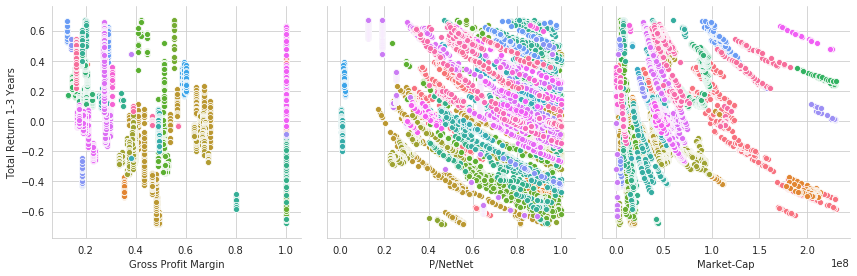

In [52]:
# Plot these signals on the x-axis.
x_vars = [GROSS_PROFIT_MARGIN, P_NETNET, MARKET_CAP]

# Plot the stock-returns on the y-axis
y_vars = [TOTAL_RETURN_1_3Y]

# Create the plots.
g = sns.PairGrid(df_sig_rets.reset_index(), height=4,
                 x_vars=x_vars, y_vars=y_vars, hue=TICKER)
g.map(sns.scatterplot);

The colours in these plots represent different stock-tickers. The Gross Profit Margin was found to be the most important signal for predicting the future stock-returns over 1-3 year investment periods, because it had the highest R-squared value. But when we look at its scatter-plot, there is no clear relation between the Gross Profit Margin and stock-returns.

The second scatter-plot is for the P/NetNet signal. This had a lower R-squared value than the Gross Profit Margin. But in this plot we see clear and characteristic downward-sloping curves, if we separate them by the ticker-colours.

The third scatter-plot is for the Market-Cap signal. This had nearly zero R-squared value when regressing only with this signal, thus indicating that it had nearly zero ability to predict the stock-returns. But once again we see characteristic downward-sloping curves similar to the P/NetNet signal.

## Discussion

Statistical analysis is a very blunt tool for uncovering relations between financial signals and stock-returns. Even if a statistical method finds a significant relation, it may be highly misleading because the data violates the assumptions of the statistical model. And even if the data is valid for a given statistical model, we might not be able to distinguish between correlation and causation, so we cannot tell if the signal really has any predictive power.

Most academic papers in finance only use statistical methods such as regression analysis. It is therefore questionable how useful such papers really are. Some researchers think the solution is to use ever-more sophisticated statistical methods, but that only seems to bring them further away from uncovering the true relation in the data.

Plotting the data may reveal much more than statistical methods can. In the examples above, we saw how the scatter-plot of the P/NetNet ratio versus the stock-returns had characteristic downward-sloping curves, when we separated the data according to the different colours for the stock-tickers. The curves were apparently just shifted up or down for the different stock-tickers, but otherwise the curve had a common shape for the stocks. This observation is a great starting-point for further scientific inquiry into the true relation between the P/NetNet ratio and stock-returns.

Interestingly, a very similar discovery was already made [here](https://github.com/Hvass-Labs/FinanceOps/blob/master/01B_Better_Long-Term_Stock_Forecasts.ipynb) when using the P/Sales ratio to predict long-term stock-returns of some major stocks, as well as the S&P 500 stock-market index as a whole. The exact formula for the downward-sloping curves was derived [here](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) and actually follows from the definition of annualized return. When using the P/Sales ratio as the predictor variable, there are only 3 underlying sources of stock-return for the long-term investor: The dividend yield, sales growth, and the change in P/Sales ratio. From our experiments above, it seems that something similar might hold for NetNet-stocks. 

This is a good lesson on how to do proper science in finance. If physicists only used statistical methods, we would still not know any laws of physics. But most academic researchers in finance don't venture beyond the statistical methods, so they cannot discover how finance actually works, and that is why academic finance is still in the dark ages. This is unfortunate for the world, because it probably causes the extremely volatile stock-markets we often experience. But it is very fortunate for you, because it means there are plenty of opportunities for you to make important scientific discoveries in finance. Hopefully this dataset and beautiful Python API will help you change the world.

## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
